# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [120]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, 'layer1')
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, 'layer2')
    # Вихідний шар
    self.layer_output = DenseLayer(n_hidden_2, num_classes, 'output')


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax    
    x = self.layer1(x,0)
    x = self.layer2(x,0)
    return self.layer_output(x, 1)

In [143]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    #print('y_true=', y_true.numpy()[:5])
    #print('y_pred=', y_pred.numpy()[:5])
    y_true = tf.cast(y_true, tf.int64)
    #print('y_true_cast=', y_true.numpy()[:5])
    predict = tf.argmax(y_pred, axis=1)
    #print('argmax(y_pred)=', predict.numpy()[:5])
    correct_pred = tf.equal(predict, y_true)
    #print('correct_pred=', correct_pred.numpy()[:5])
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return accuracy
    


In [122]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")
neural_net_adam = NN(name="mnist_adam")

# Функція навчання нейромережі
# для більшої цікавості мінімально змінимо функцію щоб можна було вікликати тренування не тільки з SGD, але і з Adam оптимізатором
def train(neural_net, input_x, output_y, opt):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  if opt:
    optimizer = tf.optimizers.SGD(learning_rate)
  else:
    optimizer = tf.optimizers.Adam(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    params = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    grads = g.gradient(loss, params)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(grads, params))

In [123]:
loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.

# Тренування для нейромережі з SGD оптимізатором
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y, True)

    if step % display_step == 0:
        pred = neural_net(batch_x)        
        loss = cross_entropy(pred, batch_y)        
        accur = accuracy(pred, batch_y)        
        loss_history.append(loss)
        accuracy_history.append(accur)
        print(f'step: {step}, loss: {loss}, accuracy: {accur}')
        
print('End of learning')


y_true_cast= [0 2 0 3 0]
argmax(y_pred)= [0 2 9 7 0]
step: 100, loss: 318.7705078125, accuracy: 0.66015625
y_true_cast= [5 5 7 3 2]
argmax(y_pred)= [5 5 7 3 2]
step: 200, loss: 235.10140991210938, accuracy: 0.76171875
y_true_cast= [0 3 1 1 0]
argmax(y_pred)= [0 0 1 1 0]
step: 300, loss: 161.72055053710938, accuracy: 0.80859375
y_true_cast= [4 7 8 6 9]
argmax(y_pred)= [4 7 9 6 9]
step: 400, loss: 164.08306884765625, accuracy: 0.80859375
y_true_cast= [5 9 4 9 1]
argmax(y_pred)= [5 9 8 9 1]
step: 500, loss: 182.390380859375, accuracy: 0.81640625
y_true_cast= [6 4 7 4 8]
argmax(y_pred)= [6 4 7 4 8]
step: 600, loss: 128.88803100585938, accuracy: 0.84765625
y_true_cast= [8 1 9 4 8]
argmax(y_pred)= [8 1 9 0 8]
step: 700, loss: 119.65983581542969, accuracy: 0.87890625
y_true_cast= [4 9 9 5 1]
argmax(y_pred)= [4 9 9 5 1]
step: 800, loss: 97.83196258544922, accuracy: 0.875
y_true_cast= [6 0 2 8 0]
argmax(y_pred)= [6 0 2 1 0]
step: 900, loss: 101.49771881103516, accuracy: 0.87890625
y_true_cast= 

In [124]:
# Тренування мережі

loss_history_adam = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history_adam = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.

# Тренування для нейромережі з Adam оптимізатором
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net_adam, batch_x, batch_y, False)

    if step % display_step == 0:
        pred = neural_net_adam(batch_x)        
        loss = cross_entropy(pred, batch_y)        
        accur = accuracy(pred, batch_y)        
        loss_history_adam.append(loss)
        accuracy_history_adam.append(accur)
        print(f'step: {step}, loss: {loss}, accuracy: {accur}')
        
print('End of learning')


y_true_cast= [5 5 0 2 8]
argmax(y_pred)= [9 3 0 2 8]
step: 100, loss: 458.95989990234375, accuracy: 0.58203125
y_true_cast= [8 4 6 9 1]
argmax(y_pred)= [8 4 6 9 1]
step: 200, loss: 275.124755859375, accuracy: 0.7265625
y_true_cast= [9 4 2 1 6]
argmax(y_pred)= [9 4 2 1 6]
step: 300, loss: 170.75535583496094, accuracy: 0.8515625
y_true_cast= [4 6 5 2 5]
argmax(y_pred)= [4 6 5 2 5]
step: 400, loss: 125.56751251220703, accuracy: 0.8671875
y_true_cast= [8 3 0 9 6]
argmax(y_pred)= [8 3 0 9 6]
step: 500, loss: 92.09566497802734, accuracy: 0.8984375
y_true_cast= [8 3 5 1 1]
argmax(y_pred)= [8 3 5 1 1]
step: 600, loss: 121.18981170654297, accuracy: 0.86328125
y_true_cast= [9 6 5 2 7]
argmax(y_pred)= [9 6 5 2 7]
step: 700, loss: 74.85205078125, accuracy: 0.90625
y_true_cast= [3 8 2 8 9]
argmax(y_pred)= [3 8 2 8 9]
step: 800, loss: 81.67437744140625, accuracy: 0.9140625
y_true_cast= [8 8 6 1 5]
argmax(y_pred)= [3 8 4 1 5]
step: 900, loss: 75.78336334228516, accuracy: 0.9140625
y_true_cast= [3 0 6

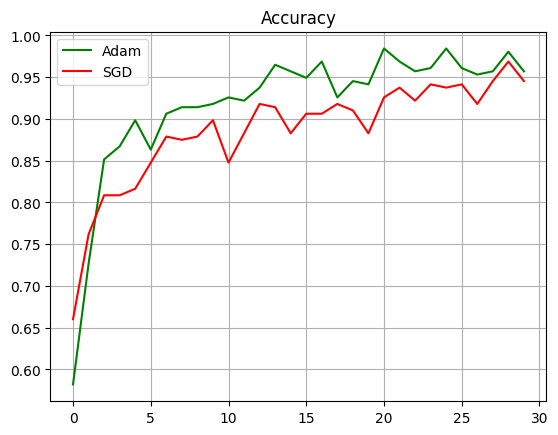

In [128]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
# порівняємо між собою 2 алгоритми
plt.plot(accuracy_history_adam, c='g', label='Adam')
plt.plot(accuracy_history, c='r', label='SGD')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()

# Виведіть графік точності
# Місце для вашого коду


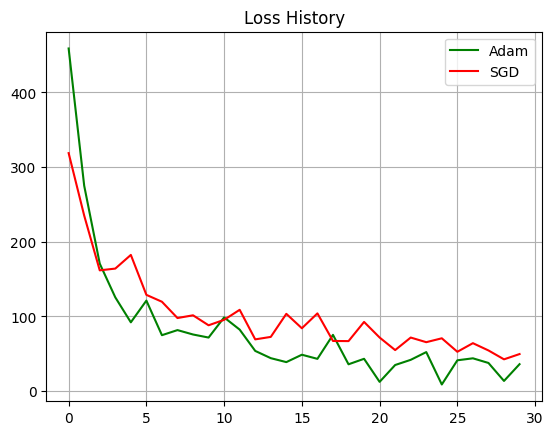

In [127]:
plt.plot(loss_history_adam, c='green', label='Adam')
plt.plot(loss_history, c='red', label='SGD')
plt.title('Loss History')
plt.grid()
plt.legend()
plt.show()

In [165]:
from sklearn.metrics import classification_report

# Обчисліть точність навченої нейромережі

# Тестування моделі на тестових даних

predictions_test = neural_net(x_test).numpy().argmax(axis=1)
#a=classification_report(y_test, predictions_test, output_dict=True)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6','class 7', 'class 8', 'class 9']
print(classification_report(y_test, predictions_test, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.94      0.95      0.95       980
     class 1       0.97      0.98      0.97      1135
     class 2       0.91      0.88      0.90      1032
     class 3       0.87      0.90      0.88      1010
     class 4       0.88      0.90      0.89       982
     class 5       0.86      0.88      0.87       892
     class 6       0.92      0.92      0.92       958
     class 7       0.91      0.90      0.91      1028
     class 8       0.88      0.83      0.85       974
     class 9       0.87      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [166]:
# побудуємо confusion_matrix щоб унаочнюти продуктивність нашого алгоритму можкмо побачити, чи допускає система невідповідності між прогнозованим і справжніми значеннями
confusion_matrix(y_test, predictions_test)

array([[ 935,    0,    2,    4,    1,   15,   14,    3,    4,    2],
       [   0, 1108,    3,    5,    1,    2,    5,    3,    8,    0],
       [   7,    3,  912,   26,   17,    4,   13,   16,   28,    6],
       [   5,    1,   14,  906,    1,   35,    1,   15,   24,    8],
       [   2,    0,   11,    2,  882,    6,   12,    9,   11,   47],
       [   8,    3,    1,   37,    8,  786,   13,    5,   22,    9],
       [  16,    4,   12,    1,   16,   17,  883,    4,    5,    0],
       [   1,   10,   24,   11,    9,    4,    1,  929,    2,   37],
       [  15,    4,   17,   37,   10,   38,   14,   11,  810,   18],
       [   7,    6,    3,   11,   58,    9,    3,   24,   10,  878]],
      dtype=int64)

Очікуване:             [7 2 1 0 4 1 4 9 5 9]
Відповідь нейромережі: [7 2 1 0 4 1 4 4 6 9]


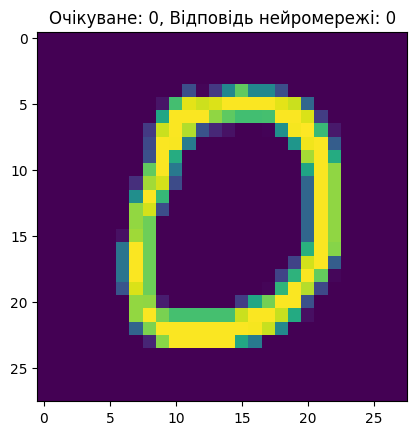

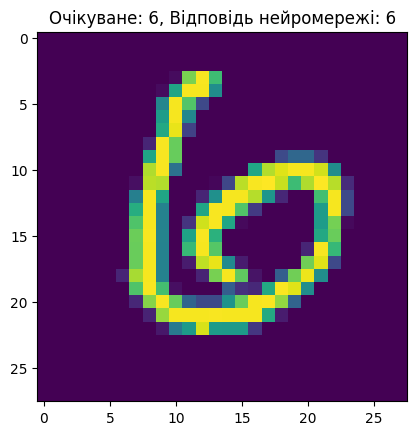

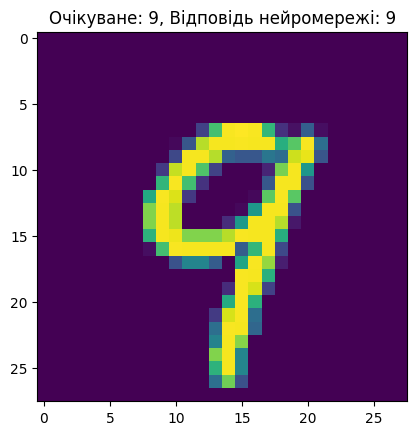

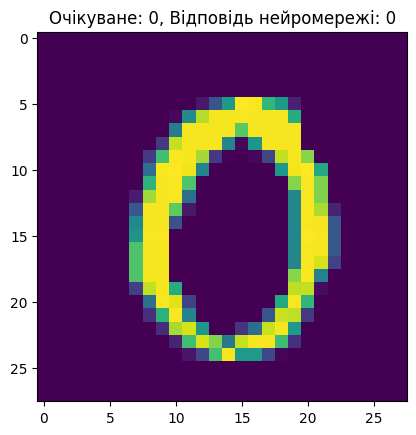

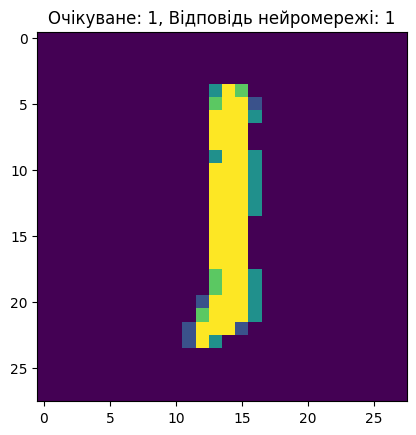

In [142]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?
test_images_10 = x_test[:10]
test_labels_10 = y_test[:10]
predictions_10 = neural_net(test_images_10)
print('Очікуване:            ', test_labels_10)
print('Відповідь нейромережі:', predictions_10.numpy().argmax(axis=1))


test_images = x_test[10:15]
test_labels = y_test[10:15]
predictions = neural_net(test_images)
for test_image, prediction, expected in zip(test_images, predictions.numpy().argmax(axis=1), test_labels):
    plt.imshow(test_image.reshape(28, 28))
    plt.title(f'Очікуване: {expected}, Відповідь нейромережі: {prediction}')
    plt.show()

# з протестованих отут 15 цифр нейромережа помилилася 2 рази з 15 тестових тож на даній малій вибірці точність склал 13/15, тобто 0.8666666666666667
# ролти 0.9 що дала нам classification_report
# тести проводилися для нейромережі навчаній з стохастичним оптимизатором, сподіваюсь для версіїї Адам яка показала на графиках кращі показники
# loss та accuracy тести були б краще